In [2]:
suppressMessages(library("rwwa"))

mdl_args <- list(dist = "gev", type = "fixeddisp")

rps_gmstonly <- c("SriLanka" = 30, "SumatraMalayThai-LAND" = 70)
rps_gmstiodnino <- c("SumatraMalayThai-LAND" = 50)

short_rnames <- c("SriLanka" = "SL", "SumatraMalayThai-LAND" = "SMT")

png_res <- 240

## IOD & ENSO correlations

### Obs

In [ ]:
fl <- list.files("~/00_WWA_project_folder/ephemeral/SEAsiaFloods/datfiles-obs", pattern = "rx5day.+dat", full.names = T)

df_list <- sapply(fl, function(fnm) {
    load_ts(fnm, col.names = c("year", gsub(".+/|rx5dayJul-Jun_|.dat","",fnm)))
}, simplify = F)

obs <- Reduce(function(dtf1, dtf2) merge(dtf1, dtf2, by = "year", all = TRUE), df_list)

gmst <- read.table("data/gmst.txt", col.names = c("year", "gmst"))
iod <- load_ts("~/00_WWA_project_folder/ephemeral/SEAsiaFloods/datfiles-obs/iod_son.dat", col.names = c("year", "iod"))
nino <- read.csv("~/00_WWA_project_folder/ephemeral/SEAsiaFloods/datfiles-obs/nino_son.csv", col.names = c("year", "nino34"))

# combine all data & truncate to region where we have all obs
df <- Reduce(function(dtf1, dtf2) merge(dtf1, dtf2, by = "year", all = TRUE), list(gmst, iod, nino, obs))
df <- df[(df$year >= 1980) & (df$year <= 2024),]

In [ ]:
# bootstrap the correlations
nsamp <- 1000
boot_res <- list()
i <- 1
f <- 0
while (length(boot_res) < nsamp) {
    boot_df <- df[sample(1:nrow(df), replace = T), ]
    boot_res[[i]] <- cor(boot_df[,-1])
    i <- i + 1
}
corr_est <- cor(df[,-1])
corr_lower <- apply(abind::abind(boot_res, rev.along = 0), 1:2, quantile, 0.025) 
corr_upper <- apply(abind::abind(boot_res, rev.along = 0), 1:2, quantile, 0.975)

In [102]:
corrs_to_check <- list(c("gmst-iod"), c("gmst-nino34"), c("iod-nino34"))
corrs_to_check <- append(append(corrs_to_check, as.list(paste0("iod-",colnames(df)[-(1:4)]))), as.list(paste0("nino34-",colnames(df)[-(1:4)])))
names(corrs_to_check) <- corrs_to_check

In [ ]:
corrs <- t(sapply(corrs_to_check, function(cpair) {
    cpair <- strsplit(cpair, "-")[[1]]
    c("est" = corr_est[cpair[1], cpair[2]], "lower" = corr_lower[cpair[1], cpair[2]], "upper" = corr_upper[cpair[1], cpair[2]])
}))

In [ ]:
write.csv(corrs, "corrs/corrs-obs.csv")

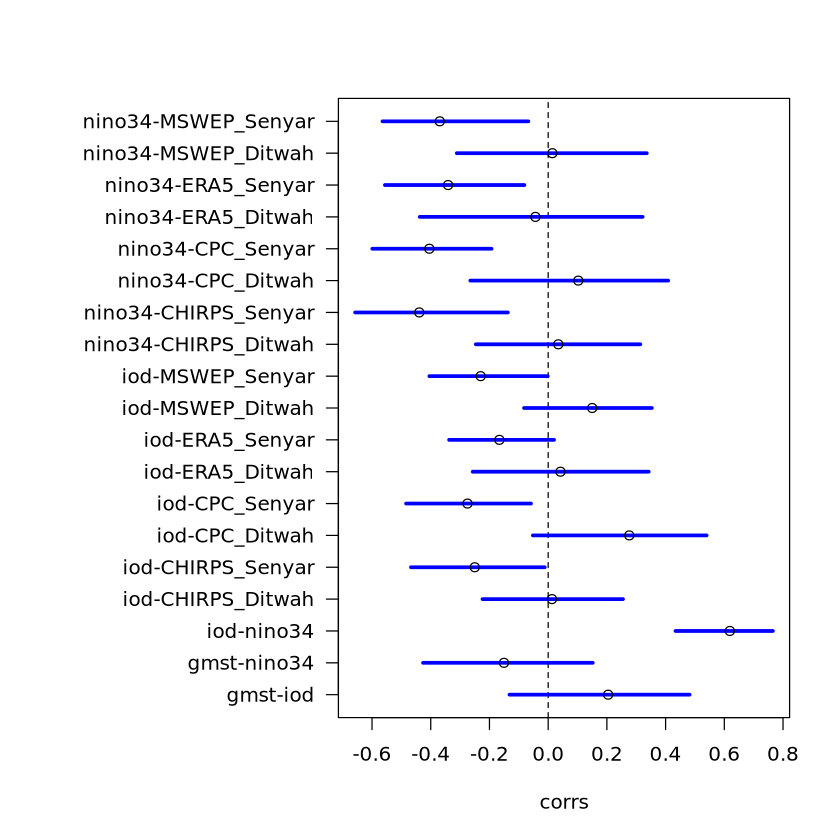

In [132]:
par(oma = c(0,10,0,0))
matplot(corrs, 1:nrow(corrs), type = "n", yaxt = "n", ylab = "")
abline(v = 0, lty = 2)

segments(x0 = corrs[,2], x1 = corrs[,3], y0 = 1:nrow(corrs), col = "blue", lwd = 3)
points(corrs[,1], 1:nrow(corrs))
axis(2, at = 1:nrow(corrs), labels = rownames(corrs), las = 1)

### CORDEX

In [197]:
rnm <- "SumatraMalayThai-LAND" # "SriLanka" #
nsamp <- 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
short_rnm <- short_rnames[rnm]

corrs_to_check <- list(c("gmst-iod"), c("gmst-nino34"), c("iod-nino34"), "gmst-rx5day", "iod-rx5day", "nino34-rx5day")
names(corrs_to_check) <- corrs_to_check

for (fnm in list.files("ts-dat", pattern = paste0("rx5day-",short_rnm), full.names = T)) {

    gcm <- paste0(strsplit(fnm, "_")[[1]][4:5], collapse = "_")
    mnm <- gsub(".dat","",paste0(strsplit(fnm, "_")[[1]][3:6], collapse = "_"))
    print(mnm)
    # if (mdl %in% c("CNRM-CM5_r1i1p1_ALADIN53","HadGEM2-ES_r1i1p1_HadREM3-GA7-05")) next
                
    corr_fnm <- gsub(".+/SEA-floods", "corrs/corr", gsub(".dat", ".csv", fnm))
    if (file.exists(corr_fnm)) next
    
    gmst_fnm <- list.files("ts-dat", pattern = paste0("gsat_", gsub("_", "_rcp85_", gsub("i1p1","",gcm))), full.names = T)
    iod_fnm <- list.files("ts-dat", pattern = paste0("iod-son_", gcm), full.names = T)
    nino34_fnm <- list.files("ts-dat", pattern = paste0("nino34-son_", gcm), full.names = T)
    if(length(gmst_fnm) == 0) next
    
    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "rx5day"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    if(length(iod_fnm) == 0) next else iod <- load_ts(iod_fnm, col.names = c("year", "iod"))
    if(length(nino34_fnm) == 0) next else nino <- load_ts(nino34_fnm, col.names = c("year", "nino34"))
    
    df <- Reduce(function(dtf1, dtf2) merge(dtf1, dtf2, by = "year", all = TRUE), list(gmst, iod, nino, ts))
    df <- df[(df$year >= 1980) & (df$year <= 2025),]

    # bootstrap the correlations
    boot_res <- list()
    i <- 1
    f <- 0
    while (length(boot_res) < 1000) {
        boot_df <- df[sample(1:nrow(df), replace = T), ]
        boot_res[[i]] <- cor(boot_df[,-1])
        i <- i + 1
    }
    corr_est <- cor(df[,-1])
    corr_lower <- apply(abind::abind(boot_res, rev.along = 0), 1:2, quantile, 0.025) 
    corr_upper <- apply(abind::abind(boot_res, rev.along = 0), 1:2, quantile, 0.975)
                 
    # make dataframe of the correlations we're interested in
    corrs <- t(sapply(corrs_to_check, function(cpair) {
        cpair <- strsplit(cpair, "-")[[1]]
        c("est" = corr_est[cpair[1], cpair[2]], "lower" = corr_lower[cpair[1], cpair[2]], "upper" = corr_upper[cpair[1], cpair[2]])
    }))
    write.csv(corrs, corr_fnm)
}
print("Done.")

[1] "SEA-22_CNRM-CM5_r1i1p1_RCA4"
[1] "SEA-22_EC-EARTH_r1i1p1_RegCM4-3"
[1] "SEA-22_GFDL-ESM2M_r1i1p1_RegCM4-3"
[1] "SEA-22_HadGEM2-ES_r1i1p1_RCA4"
[1] "SEA-22_HadGEM2-ES_r1i1p1_RegCM4-3"
[1] "SEA-22_HadGEM2-ES_r1i1p1_RegCM4-7"
[1] "SEA-22_HadGEM2-ES_r1i1p1_REMO2015"
[1] "SEA-22_IPSL-CM5A-LR_r1i1p1_RegCM4-3"
[1] "SEA-22_MPI-ESM-LR_r1i1p1_REMO2015"
[1] "SEA-22_MPI-ESM-MR_r1i1p1_RegCM4-3"
[1] "SEA-22_MPI-ESM-MR_r1i1p1_RegCM4-7"
[1] "SEA-22_NorESM1-M_r1i1p1_RegCM4-7"
[1] "SEA-22_NorESM1-M_r1i1p1_REMO2015"
[1] "Done."


## Quick visual check

In [227]:
corr_obs <- read.csv("corrs/corrs-obs.csv", row.names = "X")

In [ ]:
fl <- list.files("corrs", pattern = "rx5day", full.names = T)
mdl_corrs <- t(sapply(fl, function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))

In [384]:
mdl_sl <- mdl_corrs[grepl("rx5day-SL", rownames(mdl_corrs)),]
mdl_mt <- mdl_corrs[grepl("rx5day-SMT", rownames(mdl_corrs)),]

In [385]:
obs_mt <- corr_obs[grepl("Senyar", rownames(corr_obs)),]
obs_sl <- corr_obs[grepl("Ditwah", rownames(corr_obs)),]

In [386]:
obs_var <- corr_obs[!grepl("_", rownames(corr_obs)),]
mdl_var <- mdl_sl[,!grepl("rx5day", colnames(mdl_sl))]
rownames(mdl_var) <- apply(sapply(strsplit(rownames(mdl_var), "_"), "[", 4:5), 2, paste0, collapse = "_")
mdl_var <- mdl_var[!duplicated(rownames(mdl_var)),]

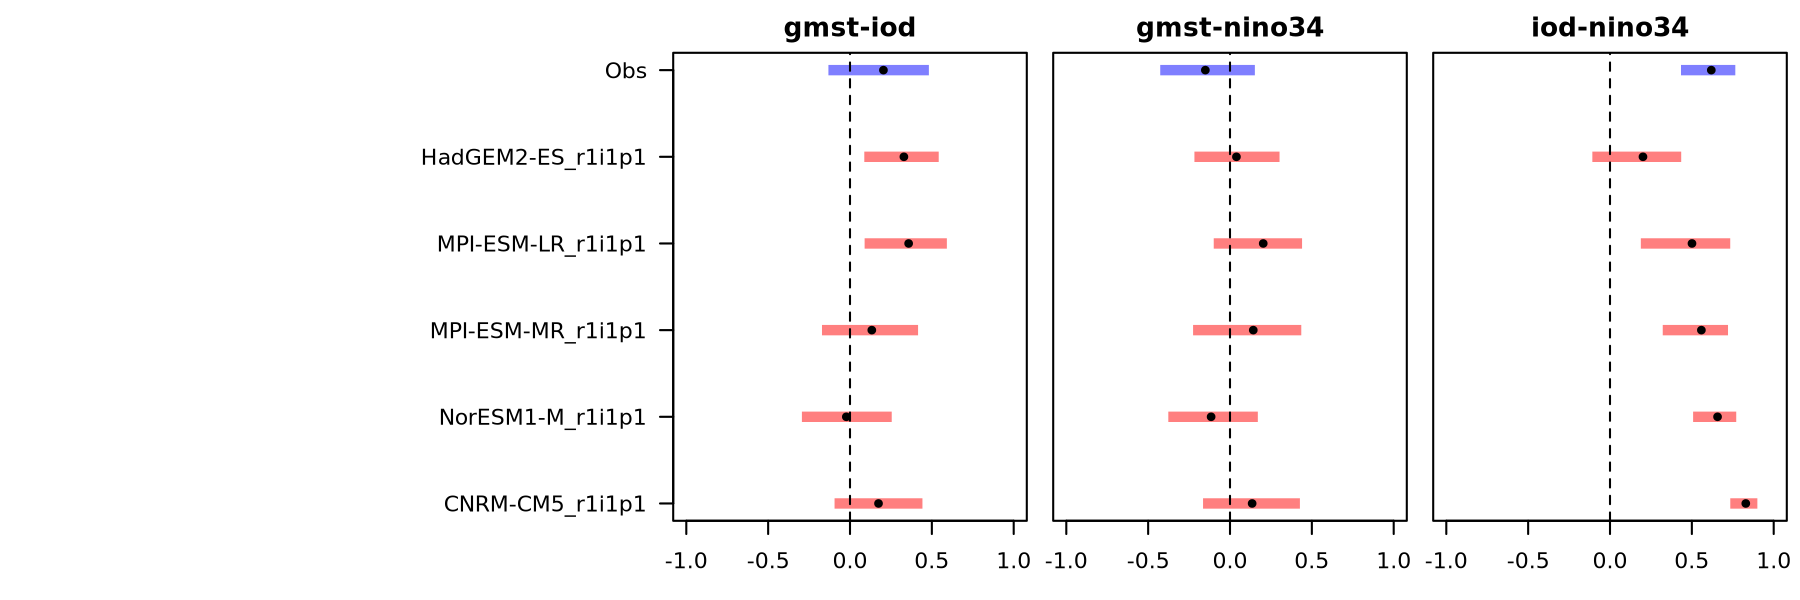

In [387]:
prep_window(c(1,3), mar = c(3,0.5,2,0.5), oma = c(0,25,0,0), w = 3, h = 3)
for (i in 1:3) {
    cnm <- rownames(obs_var)[i]

    c_obs <- obs_var[cnm,]
    rownames(c_obs) <- "Obs"
    c_mdl <- mdl_var[,grepl(cnm, colnames(mdl_var))]
    colnames(c_mdl) <- colnames(c_obs)
    c_df <- rbind(c_obs, c_mdl)

    matplot(c_df, nrow(c_df):1, xlab = "Correlation", type = "n", ylab = "", yaxt = "n", main = cnm, xlim = c(-1,1))
    segments(x0 = c_df[,2], x1 = c_df[,3], y0 = nrow(c_df):1, col = adjustcolor(c("blue", rep("red", nrow(c_mdl))), 0.5),
             lwd = 5, lend = "butt")
    points(c_df[,1], nrow(c_df):1)

    if (i == 1) axis(2, at = nrow(c_df):1, labels = rownames(c_df), las = 1)
    abline(v = 0, lty = 2)
}

In [389]:
png_res <- 360

png("fig/mdl-eval_corrs_rx5day-MT.png", h = png_res, w = png_res*3); {
    prep_window(c(1,2), mar = c(3,0.5,2,0.5), oma = c(0,25,0,0), w = 5, h = 6)
    for (i in 1:2) {
        cnm <- c("iod", "nino34")[i]
    
        c_obs <- obs_mt[grepl(cnm, rownames(obs_mt)),]
        rownames(c_obs) <- gsub(".+-|_.+", "", rownames(c_obs))
        c_mdl <- mdl_mt[,grepl(paste0(cnm, "-rx5day"), colnames(mdl_mt))]
        colnames(c_mdl) <- colnames(c_obs)
        rownames(c_mdl) <- gsub(".+-SMT_|.csv","",rownames(c_mdl))
        
        c_df <- rbind(c_obs, c_mdl)
    
        matplot(c_df, nrow(c_df):1, xlab = "Correlation", type = "n", ylab = "", yaxt = "n", main = cnm, xlim = c(-1,1))
        segments(x0 = c_df[,2], x1 = c_df[,3], y0 = nrow(c_df):1, col = adjustcolor(c(rep("blue", nrow(c_obs)), rep("red", nrow(c_mdl))), 0.5),
                 lwd = 5, lend = "butt")
        points(c_df[,1], nrow(c_df):1)
    
        if (i == 1) axis(2, at = nrow(c_df):1, labels = rownames(c_df), las = 1)
        abline(v = 0, lty = 2)
    }
}; dev.off()

agg_record_1780397199 
                    2

In [381]:
png_res <- 360

png("fig/mdl-eval_corrs_rx5day-SL.png", h = png_res, w = png_res*3); {
    prep_window(c(1,2), mar = c(3,0.5,2,0.5), oma = c(0,25,0,0), w = 5, h = 6)
    for (i in 1:2) {
        cnm <- c("iod", "nino34")[i]
    
        c_obs <- obs_sl[grepl(cnm, rownames(obs_sl)),]
        rownames(c_obs) <- gsub(".+-|_.+", "", rownames(c_obs))
        c_mdl <- mdl_sl[,grepl(paste0(cnm, "-rx5day"), colnames(mdl_sl))]
        colnames(c_mdl) <- colnames(c_obs)
        rownames(c_mdl) <- gsub(".+-SL_|.csv","",rownames(c_mdl))
        
        c_df <- rbind(c_obs, c_mdl)
    
        matplot(c_df, nrow(c_df):1, xlab = "Correlation", type = "n", ylab = "", yaxt = "n", main = cnm, xlim = c(-1,1))
        segments(x0 = c_df[,2], x1 = c_df[,3], y0 = nrow(c_df):1, col = adjustcolor(c(rep("blue", nrow(c_obs)), rep("red", nrow(c_mdl))), 0.5),
                 lwd = 5, lend = "butt")
        points(c_df[,1], nrow(c_df):1)
    
        if (i == 1) axis(2, at = nrow(c_df):1, labels = rownames(c_df), las = 1)
        abline(v = 0, lty = 2)
    }
}; dev.off()

agg_record_742444098 
                   2

# GMST + IOD + Nino

In [1]:
# filter models to get only those that pass evaluation
fl <- list.files("corrs", pattern = "rx5day", full.names = T)
mdl_corrs <- t(sapply(fl, function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))

corrs_smt <- mdl_corrs[grepl("rx5day-SMT", rownames(mdl_corrs)), ]
corrs_smt <- corrs_smt[corrs_smt[,"nino34-rx5day_est"] < 0,]

In [ ]:
mlist <- gsub(".+corr_|.csv","",rownames(corrs_smt))
nsamp <- 1000
rp <- 50

for (fnm in mlist) {
    print(fnm)
    
    gcm <- paste0(strsplit(fnm, "_")[[1]][3:4], collapse = "_")
    mnm <- gsub(".dat","",paste0(strsplit(fnm, "_")[[1]][2:5], collapse = "_"))

    res_fnm <- paste0("res/res-gmst+iod+nino_SEA-floods_", fnm, ".csv")
    if (file.exists(res_fnm)) next
    
    ts <- load_ts(paste0("ts-dat/SEA-floods_",fnm,".dat"), col.names = c("year", "x"))
    gmst <- load_ts(list.files("ts-dat", pattern = paste0("gsat_", gsub("_", "_rcp85_", gsub("i1p1","",gcm))), full.names = T), col.names = c("year", "gmst"))
    iod <- load_ts(list.files("ts-dat", pattern = paste0("iod-son_", gcm), full.names = T), col.names = c("year", "iod"))
    nino34 <- load_ts(list.files("ts-dat", pattern = paste0("nino34-son_", gcm), full.names = T), col.names = c("year", "nino34"))

    df <- Reduce(function(dtf1, dtf2) merge(dtf1, dtf2, by = "year", all.y = TRUE), list(gmst, iod, nino34, ts))
    df <- df[!is.na(rowSums(df)),]

                 # pick up model to be fitted depending on variable
    mdl <- tryCatch({
            do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = c("gmst", "nino34", "iod"), lower = F)))
        }, error = function(cond) {
            return(NULL)
        })
    if (is.null(mdl)) { 
        # if normal optimisation fails, use slower but more robust approach
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = c("gmst", "nino34", "iod"), lower = F, "method" = "Nelder-Mead")))
    }
    
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,c("gmst","iod","nino34"),drop = F]
    cov_hist <- cov_now - c(1.3,0,0)
    cov_fut <- cov_now + c(1.3,0,0)

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                          y_now = 2025, y_start = 1950, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/res.+?_", "fig/mdl-eval_rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = mnm)
        }; dev.off()
    }
}